In [1]:
# --- Set location of XASNet code
import sys
#sys.path.append('/home/samjhall/github/XASNet-XAI/src')
sys.path.append('D:\github\XASNet-XAI\src')
# --- Standard libraries
import os.path as osp
import heapq as hq
import matplotlib.pyplot as plt
# --- PyTorch
import torch
# --- XASNet
from XASNet.models import XASNet_GNN
from XASNet.utils import GraphDataProducer
from XASNet.utils.visualisation import plot_prediction
from XASNet.utils.rse import rse_predictions, rse_loss, rse_histogram

In [4]:
# --- Load in the test dataset
test_go = torch.load('./XASNet-data/test_mol_dataset.pt')

In [5]:
# --- Print details of the dataset
print(f'Number of graphs: {len(test_go)}')
print('')

# --- Print details of the first molecule/graph in the dataset
data = test_go[0]

print(data)
print('------------')
print(f'Molecule index: {data.idx}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 39

Data(x=[30, 15], edge_index=[2, 72], edge_attr=[72, 6], spectrum=[200], idx=[1], smiles='[c:0]12[c:2]3[cH:1][cH:25][c:24]4[c:22]1[c:18]1[c:13]5[c:10]6[c:4]2[c:6]([c:5]([C:8](=[O:27])[OH:28])[cH:3]3)[C:7](=[O:9])[CH2:11][c:12]6[cH:29][c:14]([OH:26])[c:15]5[C:16](=[O:17])[CH2:19][c:20]1[cH:21][cH:23]4')
------------
Molecule index: tensor([238])
Number of nodes: 30
Number of edges: 72
Average node degree: 2.40
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [7]:
data.idx

tensor([238])

In [6]:
# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Set ML model parameters to match the loaded model
xasnet_gnn = XASNet_GNN(
    gnn_name = 'gcn', # model type
    in_channels = [15, 256, 128], # input nodes for each layer
    out_channels = [256, 128, 64], # output nodes for each layer
    num_targets = 200, # nodes for final layers
    num_layers = 3, # number of layers
    heads = 1
).to(device)

# --- Location of the ML model
path_to_model = osp.join('./best_model/xasnet_model.pt')

# --- Check if there is an existing model
if osp.exists(path_to_model):
    xasnet_gnn.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

In [8]:
# --- Choose a molecule to predict spectra from
mol_idx = 238

# --- Set up model to predict spectra
graph_picker = GraphDataProducer(
    model=xasnet_gnn,
    gnn_type="gcn",
    test_data=test_go,
    idx_to_pick=mol_idx
)
graph = graph_picker.picked_graph

In [9]:
# --- Set variables for the spectra
y_true = graph.spectrum
# --- Predict spectrum from ML model
x_pred, y_pred = graph_picker.predictions()

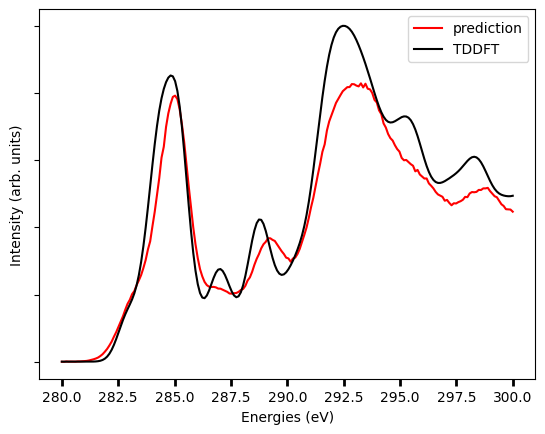

In [10]:
# --- Plot the ML predicted spectrum againsts the true TDDFT spectrum
plot_prediction(x_pred,
                y_pred,
                y_true,
                normalise=False,
                add_peaks=False,
                save=False)

In [11]:
from scipy.stats import spearmanr

spear = spearmanr(y_true, y_pred)

print(spear)
print(spear[0])

SignificanceResult(statistic=0.9762364059101479, pvalue=1.8481970092317227e-133)
0.9762364059101479


In [12]:
import numpy as np

for i in range(200):
    if y_pred[i] < 0:
        y_pred[i] = 0.00000000001

sid = 0

for i in range(200):
    temp = y_pred[i] * np.log(y_pred[i]/y_true[i]) + y_true[i] * np.log(y_true[i]/y_pred[i])
    sid = sid + temp

print(sid)

tensor(2.7631, dtype=torch.float64)


In [13]:
rse_dict = rse_predictions(xasnet_gnn, test_go, graphnet=False)

RuntimeError: scatter(): Expected dtype int64 for index

In [11]:
rse_dict = {k: v.numpy() for k, v in rse_dict.items() if v < 1}

In [12]:
rse_loss(y_pred, y_true)

tensor(0.1630, dtype=torch.float64)

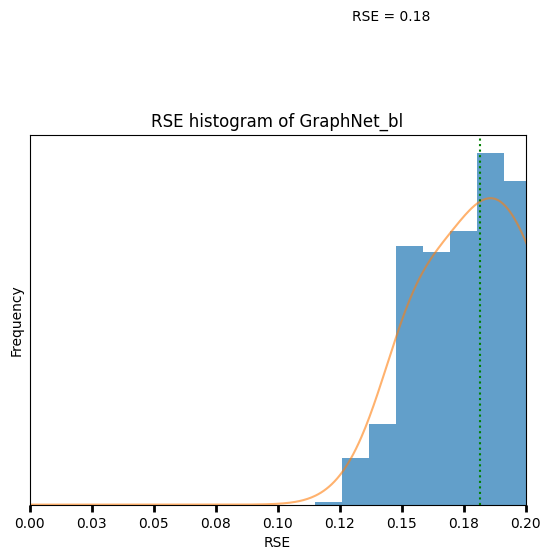

In [13]:
rse_histogram(list(rse_dict.values()), 
              bins=25, 
              quantiles=False,
              model_name="GraphNet_bl", 
              save=False)

In [14]:
min_rse = 1
max_rse = 0

for k, v in rse_dict.items():
    if v < min_rse:
        min_idx = k
        min_rse = v

    if v > max_rse:
        max_idx = k
        max_rse = v

print(f'Lowest RSE value: {min_rse}, belonging the graph index: {min_idx}')
print(f'Highest RSE value: {max_rse}, belonging to the graph index: {max_idx}')

Lowest RSE value: 0.11518137097737262, belonging the graph index: tensor([7705])
Highest RSE value: 0.38679879602332556, belonging to the graph index: tensor([3526])


In [15]:
smallest = hq.nsmallest(5, rse_dict.values())
largest = hq.nlargest(5, rse_dict.values())

In [16]:
print(smallest)

[array(0.11518137), array(0.12790163), array(0.12892076), array(0.12956051), array(0.13009107)]


In [17]:
for x in smallest:
    for k, v in rse_dict.items():
        if x == v:
            print(k)

tensor([7705])
tensor([543])
tensor([6874])
tensor([3739])
tensor([6833])


In [18]:
for x in largest:
    for k, v in rse_dict.items():
        if x == v:
            print(k)

tensor([3526])
tensor([7822])
tensor([3616])
tensor([2353])
tensor([2614])


In [19]:
average = 0

for idx, rse_val in rse_dict.items():
    average += rse_val

average = average / len(rse_dict)

print(f'Average RSE value of test data: {average}')

Average RSE value of test data: 0.19899596735665093


In [20]:
# --- Choose a molecule to predict spectra from
mol_idx = 2614

# --- Set up model to predict spectra
graph_picker = GraphDataProducer(
    model=xasnet_gnn,
    gnn_type="gcn",
    test_data=test_go,
    idx_to_pick=mol_idx
)
graph = graph_picker.picked_graph

In [21]:
graph

Data(x=[34, 15], edge_index=[2, 82], edge_attr=[82, 6], spectrum=[200], vector=[15], idx=[1], smiles='[c:0]12[c:2]3[cH:1][c:24]([CH:25]=[O:33])[c:23]4[c:21]1[c:17]1[c:12]5[c:14]([c:15]([C:16](=[O:26])[OH:27])[cH:18][c:19]1[cH:20][c:22]4[CH:29]=[O:31])[CH:13]=[C:11]([CH:28]=[O:32])[C:10]14[C:8]5([c:4]2[c:6]([cH:5][cH:3]3)[CH:7]=[CH:9]1)[O:30]4', atom_num=[1], neighbors=[3], batch=[34])

In [22]:
# --- Set variables for the spectra
y_true = graph.spectrum
# --- Predict spectrum from ML model
x_pred, y_pred = graph_picker.predictions()

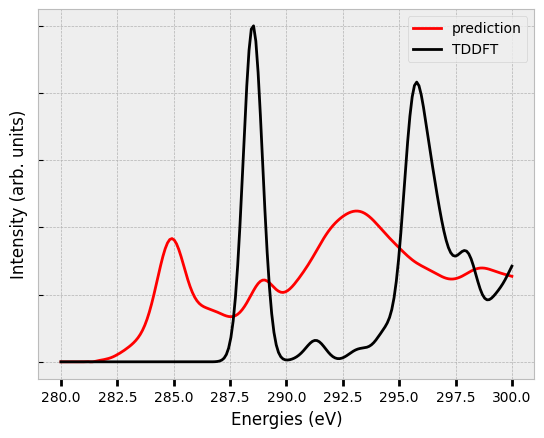

In [28]:
# --- Plot the ML predicted spectrum againsts the true TDDFT spectrum
plot_prediction(x_pred,
                y_pred,
                y_true,
                normalise=False,
                add_peaks=False,
                save=False)

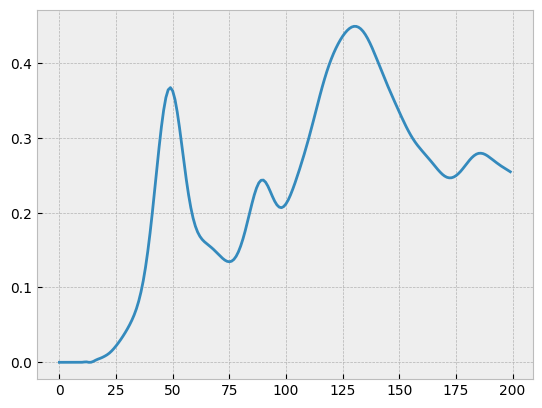

In [27]:
plt.plot(y_pred)